In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/major_project_data/"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Embedding, Dense,
    Concatenate, RepeatVector, Dot, Activation
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [4]:
train_df = pd.read_csv(DATA_PATH + "train.csv")
val_df   = pd.read_csv(DATA_PATH + "validation.csv")
test_df  = pd.read_csv(DATA_PATH + "test.csv")

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)


Train shape: (287113, 3)
Validation shape: (13368, 3)
Test shape: (11490, 3)


In [5]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub('"','', text)
    text = re.sub(r"'s\b","",text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub('[m]{2,}', 'mm', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text



In [6]:
train_df['article'] = train_df['article'].apply(clean_text)
train_df['highlights'] = train_df['highlights'].apply(clean_text)

val_df['article'] = val_df['article'].apply(clean_text)
val_df['highlights'] = val_df['highlights'].apply(clean_text)


In [7]:
START_TOKEN = "sostok"
END_TOKEN = "eostok"
train_df['highlights'] = START_TOKEN + " " + train_df['highlights'] + " " + END_TOKEN
val_df['highlights']   = START_TOKEN + " " + val_df['highlights'] + " " + END_TOKEN


In [8]:
MAX_TEXT_LEN = 250
MAX_SUMMARY_LEN = 40
x_tokenizer = Tokenizer(num_words=30000, oov_token="<unk>")
x_tokenizer.fit_on_texts(train_df['article'])
y_tokenizer = Tokenizer(num_words=15000, oov_token="<unk>")
y_tokenizer.fit_on_texts(train_df['highlights'])


In [9]:
x_train = pad_sequences(x_tokenizer.texts_to_sequences(train_df['article']), maxlen=MAX_TEXT_LEN)
y_train = pad_sequences(y_tokenizer.texts_to_sequences(train_df['highlights']), maxlen=MAX_SUMMARY_LEN)
x_val = pad_sequences(x_tokenizer.texts_to_sequences(val_df['article']), maxlen=MAX_TEXT_LEN)
y_val = pad_sequences(y_tokenizer.texts_to_sequences(val_df['highlights']), maxlen=MAX_SUMMARY_LEN)


In [10]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V  = Dense(1)

    def call(self, query, values):
        query_time = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_time)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector


In [11]:
class LuongAttention(tf.keras.layers.Layer):
    def call(self, decoder_output, encoder_output):
        score = tf.matmul(decoder_output, encoder_output, transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(attention_weights, encoder_output)
        return context


In [12]:
embedding_dim = 128
latent_dim = 256
encoder_inputs = Input(shape=(MAX_TEXT_LEN,))
enc_emb = Embedding(30000, embedding_dim, trainable=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)


In [13]:
decoder_inputs = Input(shape=(MAX_SUMMARY_LEN-1,))
dec_emb = Embedding(15000, embedding_dim, trainable=True)(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(
    dec_emb, initial_state=[state_h, state_c]
)
from tensorflow.keras.layers import RepeatVector, Concatenate, Dense

attention = BahdanauAttention(latent_dim)
context_vector = attention(state_h, encoder_outputs)
context_vector = RepeatVector(MAX_SUMMARY_LEN - 1)(context_vector)
decoder_concat = Concatenate(axis=-1)(
    [decoder_outputs, context_vector]
)
decoder_final = Dense(15000, activation='softmax')(decoder_concat)




In [14]:
bahdanau_model = Model([encoder_inputs, decoder_inputs], decoder_final)
bahdanau_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
)

bahdanau_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 250, 128)  │  3,840,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 250,      │    394,240 │ embedding[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 39, 128)   │  1,920,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ (None, 256)       │    131,841 │ lstm[0][1],       │
│ (BahdanauAttention) │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 39, 256), │    394,240 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 39, 256)   │          0 │ bahdanau_attenti… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 39, 512)   │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 39, 15000) │  7,695,000 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,375,321 (54.84 MB)

 Trainable params: 14,375,321 (54.84 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
TRAIN_SAMPLES =15000
VAL_SAMPLES = 2000

x_train_small = x_train[:TRAIN_SAMPLES]
y_train_small = y_train[:TRAIN_SAMPLES]

x_val_small = x_val[:VAL_SAMPLES]
y_val_small = y_val[:VAL_SAMPLES]

print("x_train_small:", x_train_small.shape)
print("y_train_small:", y_train_small.shape)
print("x_val_small:", x_val_small.shape)
print("y_val_small:", y_val_small.shape)


x_train_small: (15000, 250)
y_train_small: (15000, 40)
x_val_small: (2000, 250)
y_val_small: (2000, 40)


In [17]:
bahdanau_history = bahdanau_model.fit(
    [x_train_small, y_train_small[:, :-1]],
    y_train_small[:, 1:],
    validation_data=(
        [x_val_small, y_val_small[:, :-1]],
        y_val_small[:, 1:]
    ),
    batch_size=32,
    epochs=5
)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 6.4608 - val_loss: 6.2937
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 6.0510 - val_loss: 5.9733
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - loss: 5.7374 - val_loss: 5.8971
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 5.5405 - val_loss: 5.7356
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 5.2834 - val_loss: 5.6725


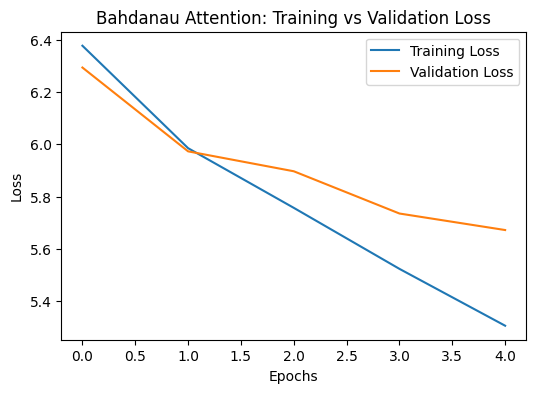

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(bahdanau_history.history['loss'], label='Training Loss')
plt.plot(bahdanau_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Bahdanau Attention: Training vs Validation Loss')
plt.legend()
plt.show()


In [19]:
decoder_inputs_l = Input(shape=(MAX_SUMMARY_LEN-1,))
dec_emb_l = Embedding(15000, embedding_dim)(decoder_inputs_l)

decoder_lstm_l = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs_l, _, _ = decoder_lstm_l(
    dec_emb_l, initial_state=[state_h, state_c]
)

score = Dot(axes=[2, 2])([decoder_outputs_l, encoder_outputs])
attention_weights = Activation('softmax')(score)
context_l = Dot(axes=[2, 1])([attention_weights, encoder_outputs])

decoder_concat_l = Concatenate(axis=-1)([decoder_outputs_l, context_l])
decoder_outputs_l = Dense(15000, activation='softmax')(decoder_concat_l)


In [20]:
luong_model = Model([encoder_inputs, decoder_inputs_l], decoder_outputs_l)
luong_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy'
)
luong_model.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 250, 128)  │  3,840,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 39, 128)   │  1,920,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 250,      │    394,240 │ embedding[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 39, 256), │    394,240 │ embedding_2[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 39, 250)   │          0 │ lstm_2[0][0],     │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 39, 250)   │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 39, 256)   │          0 │ activation[0][0], │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 39, 512)   │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ dot_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 39, 15000) │  7,695,000 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,243,480 (54.33 MB)

 Trainable params: 14,243,480 (54.33 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
luong_history = luong_model.fit(
    [x_train_small, y_train_small[:, :-1]],
    y_train_small[:, 1:],
    validation_data=(
        [x_val_small, y_val_small[:, :-1]],
        y_val_small[:, 1:]
    ),
    batch_size=32,
    epochs=5
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 68ms/step - loss: 7.0261 - val_loss: 6.3822
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - loss: 6.1559 - val_loss: 6.0447
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - loss: 5.8062 - val_loss: 5.8343
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - loss: 5.5308 - val_loss: 5.7060
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - loss: 5.3328 - val_loss: 5.6403


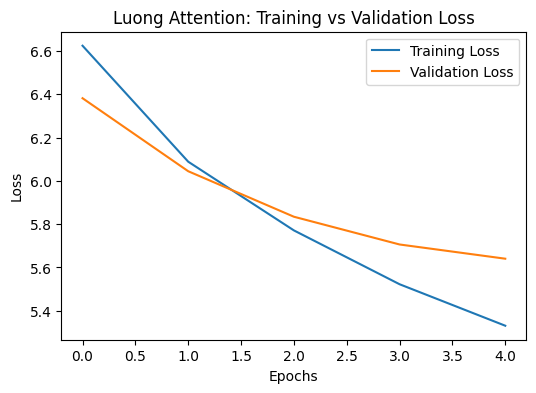

In [23]:
plt.figure(figsize=(6,4))
plt.plot(luong_history.history['loss'], label='Training Loss')
plt.plot(luong_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Luong Attention: Training vs Validation Loss')
plt.legend()
plt.show()


In [24]:
# ENCODER INFERENCE MODEL
encoder_model = Model(
    encoder_inputs,
    [encoder_outputs, state_h, state_c]
)


In [25]:
# DECODER INFERENCE MODEL

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
encoder_outputs_input = Input(shape=(MAX_TEXT_LEN, latent_dim))


decoder_inf_input = Input(shape=(1,))

# Embedding for inference
decoder_emb_inf = Embedding(
    15000, embedding_dim, trainable=True
)(decoder_inf_input)

# Decoder LSTM (one timestep)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    decoder_emb_inf,
    initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# Bahdanau attention
attention_inf = BahdanauAttention(latent_dim)
context_inf = attention_inf(state_h_inf, encoder_outputs_input)

from tensorflow.keras.layers import Reshape
context_inf = Reshape((1, latent_dim))(context_inf)

# Concatenate
decoder_concat_inf = Concatenate(axis=-1)(
    [decoder_outputs_inf, context_inf]
)

# Final softmax
decoder_outputs_inf = Dense(15000, activation='softmax')(decoder_concat_inf)

# Decoder inference model
decoder_model = Model(
    [decoder_inf_input, encoder_outputs_input,
     decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_inf, state_h_inf, state_c_inf]
)


In [26]:
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

def decode_sequence(input_seq):
    enc_out, enc_h, enc_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sostok']

    decoded_sentence = []

    for _ in range(MAX_SUMMARY_LEN):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, enc_out, enc_h, enc_c],
            verbose=0
        )

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index.get(sampled_token_index, '')

        if sampled_word == 'eostok':
            break

        decoded_sentence.append(sampled_word)
        target_seq[0, 0] = sampled_token_index
        enc_h, enc_c = h, c

    return ' '.join(decoded_sentence)


In [27]:
NUM_SAMPLES = 100

bahdanau_preds = []
luong_preds = []
references = []

for i in range(NUM_SAMPLES):
    input_seq = x_val[i].reshape(1, MAX_TEXT_LEN)

    bahdanau_summary = decode_sequence(input_seq)
    luong_summary = decode_sequence(input_seq)


    ref = ' '.join([
        reverse_target_word_index.get(idx, '')
        for idx in y_val[i]
        if idx not in [0, target_word_index['sostok'], target_word_index['eostok']]
    ])

    bahdanau_preds.append(bahdanau_summary)
    luong_preds.append(luong_summary)
    references.append(ref)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

In [28]:
for i in range(3):
    print("\n==============================")
    print(f"ARTICLE {i+1}:")
    print(val_df['article'].iloc[i][:300])

    print("\nREFERENCE SUMMARY:")
    print(val_df['highlights'].iloc[i])

    print("\nPREDICTED SUMMARY:")
    print(decode_sequence(x_val[i].reshape(1, MAX_TEXT_LEN)))



ARTICLE 1:
sally forrest an actress dancer who graced the silver screen throughout the s and s in mgm musicals and films such as the noir while the city sleeps died on march at her home in beverly hills california forrest whose birth name was katherine feeney was and had long battled cancer her publicist judit

REFERENCE SUMMARY:
sostok sally forrest an actress dancer who graced the silver screen throughout the s and s in mgm musicals and films died on march forrest whose birth name was katherine feeney had long battled cancer a san diego native forrest became a protege of hollywood trailblazer ida lupino who cast her in starring roles in films eostok

PREDICTED SUMMARY:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
donnell demise demise considers considers considers considers exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion exhaustion

In [29]:
!pip install rouge-score
from rouge_score import rouge_scorer


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2d4a2d4fe60e36acc24de2c18c1a96e57976ee854b5948dafd0ee6427accb1c0
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [30]:
scorer = rouge_scorer.RougeScorer(
    ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True
)
def average_rouge(preds, refs):
    r1 = r2 = rl = 0
    for p, r in zip(preds, refs):
        scores = scorer.score(r, p)
        r1 += scores['rouge1'].fmeasure
        r2 += scores['rouge2'].fmeasure
        rl += scores['rougeL'].fmeasure

    n = len(preds)
    return r1/n, r2/n, rl/n


In [31]:
bahdanau_rouge = average_rouge(bahdanau_preds, references)
luong_rouge = average_rouge(luong_preds, references)

print("Bahdanau ROUGE:", bahdanau_rouge)
print("Luong ROUGE:", luong_rouge)


Bahdanau ROUGE: (0.0010126582278481013, 0.0, 0.0010126582278481013)
Luong ROUGE: (0.0010126582278481013, 0.0, 0.0010126582278481013)


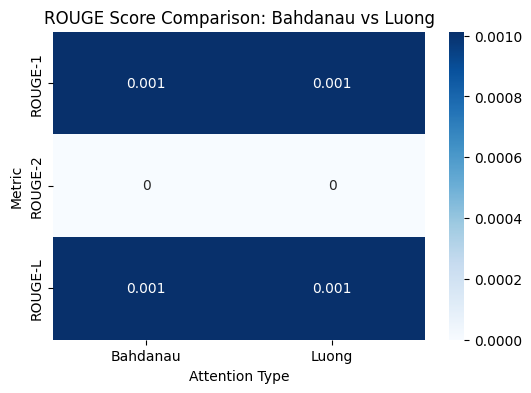

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

heatmap_data = pd.DataFrame({
    'Bahdanau': bahdanau_rouge,
    'Luong': luong_rouge
}, index=['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])

plt.figure(figsize=(6,4))
sns.heatmap(heatmap_data, annot=True, cmap='Blues')
plt.title("ROUGE Score Comparison: Bahdanau vs Luong")
plt.ylabel("Metric")
plt.xlabel("Attention Type")
plt.show()
